In [1]:
%%capture


!pip install pyvi
!pip install git+https://github.com/CodeLinkIO/vietnam-number.git@master
!pip install git+https://github.com/CodeLinkIO/Vietnamese-text-normalization.git@main
!pip install transformers datasets evaluate tensorboard scikit-learn

In [2]:
import unicodedata
import regex as re
from pyvi import ViTokenizer, ViPosTagger
from vi_cleaner.vi_cleaner import ViCleaner
import transformers
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging,ViTModel,BartForConditionalGeneration,BartConfig
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import evaluate
import seaborn as sns
logging.set_verbosity_error()
import cv2
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

from transformers import ViTModel
from tqdm import tqdm
import json

In [3]:
bang_nguyen_am= [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}
stop_words = ['ở','là','một','đây','có']
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

# Chuẩn hóa unicode
# Có 2 loại unicode : unicode tổ hơp và unicode dựng sẵn, điêu này dẫn tới việc 2 từ giống nhau sẽ bị coi là khác nhau
# Chuẩn hóa tất cả về 1 loại là unicode dựng sẵn
def chuan_hoa_unicode(text):
	text = unicodedata.normalize('NFC', text)
	return text

# Có 2 kiểu gõ dấu ở Tiếng Việt, ví dụ như là : òa hoặc oà (ta gọi lần lượt là chuẩn 1 và 2). Mặc dù kiểu gõ chữ sau ít
#phổ biến hơn tuy nhiên vẫn cần phải chuẩn hóa tránh việc một số văn bản vẫn sử dụng kiểu gõ dấu thứ 2.
"""
	Hàm này xử lý chuẩn hóa từng từ một, sau khi chuẩn hóa từng từ thì ta sẽ đi chuân hóa từng câu sau
	"""
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

# Tách từ tiếng việt, từ tiếng việt không giống như tiếng anh, tách từ tiếng anh ta chỉ cần tách bằng khoảng trắng
# Tuy nhiên từ tiếng Việt có cả từ đơn lẫn từ ghép nên tách từ tiêng Việt sẽ phúc tạp hơn
# Project sử dung thu viện pyvi (xem mã nguồn tại : https://github.com/trungtv/pyvi) để phục vụ bài toán con tách từ Tiếng Việt
def tach_tu_tieng_viet(text):
	text = ViTokenizer.tokenize(text)
	return text

# Đưa về chữ viết thường
def chuyen_chu_thuong(text):
	return text.lower()

# Xóa đi các dấu cách thừa, các từ không cần thiết cho việc phân loại vẳn bản
def chuan_hoa_cau(text):
	text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

def remove_words_with_numbers(sentence):
    # Tách các từ trong câu và giữ lại các từ không chứa số
    result = ' '.join(word for word in sentence.split() if (not re.search(r'\d', word)) and (word not in stop_words ))
    return result
def chuyen_so_thanh_chu(text):
  text = ViCleaner(text)
  return text.clean()

def tien_xu_li(text):
    text = chuan_hoa_unicode(text)
    text = chuan_hoa_dau_cau_tieng_viet(text)
    text = chuyen_so_thanh_chu(text)
    text = tach_tu_tieng_viet(text)
    text = chuyen_chu_thuong(text)
    text = chuan_hoa_cau(text)

    text = remove_words_with_numbers(text)



    return text

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, img_folder ,json_file,tokenizer,transform = None, max_len=30):
        
        self.img_folder = img_folder
        self.json_file = json_file
        self.max_len = max_len
        
        with open(json_file, 'r') as file:
            data = json.load(file)
           
        self.images = pd.DataFrame(dict(data)['images'])
        self.annotation = dict(data)['annotations']
        self.tokenizer = tokenizer
        self.transform  = transform
        if transform is None:
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                ]
            )

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):

        annotation = self.annotation[index]
        
        image_id  = annotation['image_id']
        caption  = annotation['caption']
        caption = tien_xu_li(caption)
        image_name = str(self.images[self.images.id == image_id].filename.values[0])
        image_path = os.path.join(self.img_folder,image_name)
        pil_image = Image.open(image_path)
        tensor_image = self.transform(pil_image).unsqueeze(0)
        encoding = self.tokenizer.encode_plus(
            caption,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': caption,
            'encoding':encoding['input_ids'],
            'image': tensor_image,
            "attention_mask" : encoding['attention_mask']
        }

def collator(batch):
    captions = [example['text'] for example in batch]
    images = [example['image'] for example in batch]
    encodings = [example['encoding'] for example in batch]
   
    return {'images': torch.cat(images,dim = 0),
        'captions':  captions,
        'encodings': torch.cat(encodings,dim = 0)
           }
def tensor_to_image(tensor_image,
                    mean = np.array([1,1, 1]),
                    std = np.array([0, 0, 0])
                    ):
    tensor_image = tensor_image.squeeze(0)  # Remove batch dimension
    numpy_image = tensor_image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
    # Denormalize the image
    denormalized_image = (numpy_image * std + mean) * 255
    denormalized_image = denormalized_image.astype(np.uint8)
    return denormalized_image

In [5]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
train_dataset = SentimentDataset("/kaggle/input/image-captioning/train-images","/kaggle/input/image-captioning/train_data.json",tokenizer)
train_dataloader = DataLoader(train_dataset,batch_size = 80,collate_fn=collator,shuffle=True,drop_last=True)

val_dataset = SentimentDataset("/kaggle/input/image-captioning/public-test-images","/kaggle/input/image-captioning/test_data.json",tokenizer)
val_dataloader = DataLoader(val_dataset,batch_size = 80,collate_fn=collator,shuffle=True)


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:

for data in train_dataloader:
    data = data
    break
data['captions']

['dưới hồ nước dãy đèn màu xanh lá cây',
 'người đội nón lá đang gánh cái đòn_gánh trên đường',
 'trong căn phòng sự xuất_hiện của bức tượng màu xám',
 'bốn người đang xuất_hiện bên quầy rau củ_quả',
 'logo hình con dê của quán ăn màu vàng',
 'người đang đứng trong sân của căn nhà',
 'một_vài người đang đứng phía trước quầy hàng',
 'khung_cảnh chụp khu chợ_nổi trên sông',
 'bốn cô gái đang tạo dáng chụp hình bên bàn ăn',
 'người phụ_nữ đang hướng tầm_mắt vào quầy hàng',
 'hai bên đường sự xuất_hiện của những chiếc xe_máy',
 'chàng trai và cô gái đang ngồi cạnh nhau trên vỉa_hè',
 'người đàn_ông đang tập_thể_dục bên hồ',
 'bên trong khu xưởng sự xuất_hiện của một_vài chiếc xe ô_tô',
 'trong hình sự xuất_hiện của ba đứa bé',
 'cây cầu bắc ngang qua con sông',
 'trước căn nhà sự xuất_hiện của người mặc áo trắng',
 'một_vài người đang di_chuyển bên trong khu chợ',
 'hai bức ảnh nhỏ xuất_hiện trong tấm hình',
 'xung_quanh quầy hàng rất đông người đang đứng',
 'một_vài chiếc xe_máy xuất_hiện

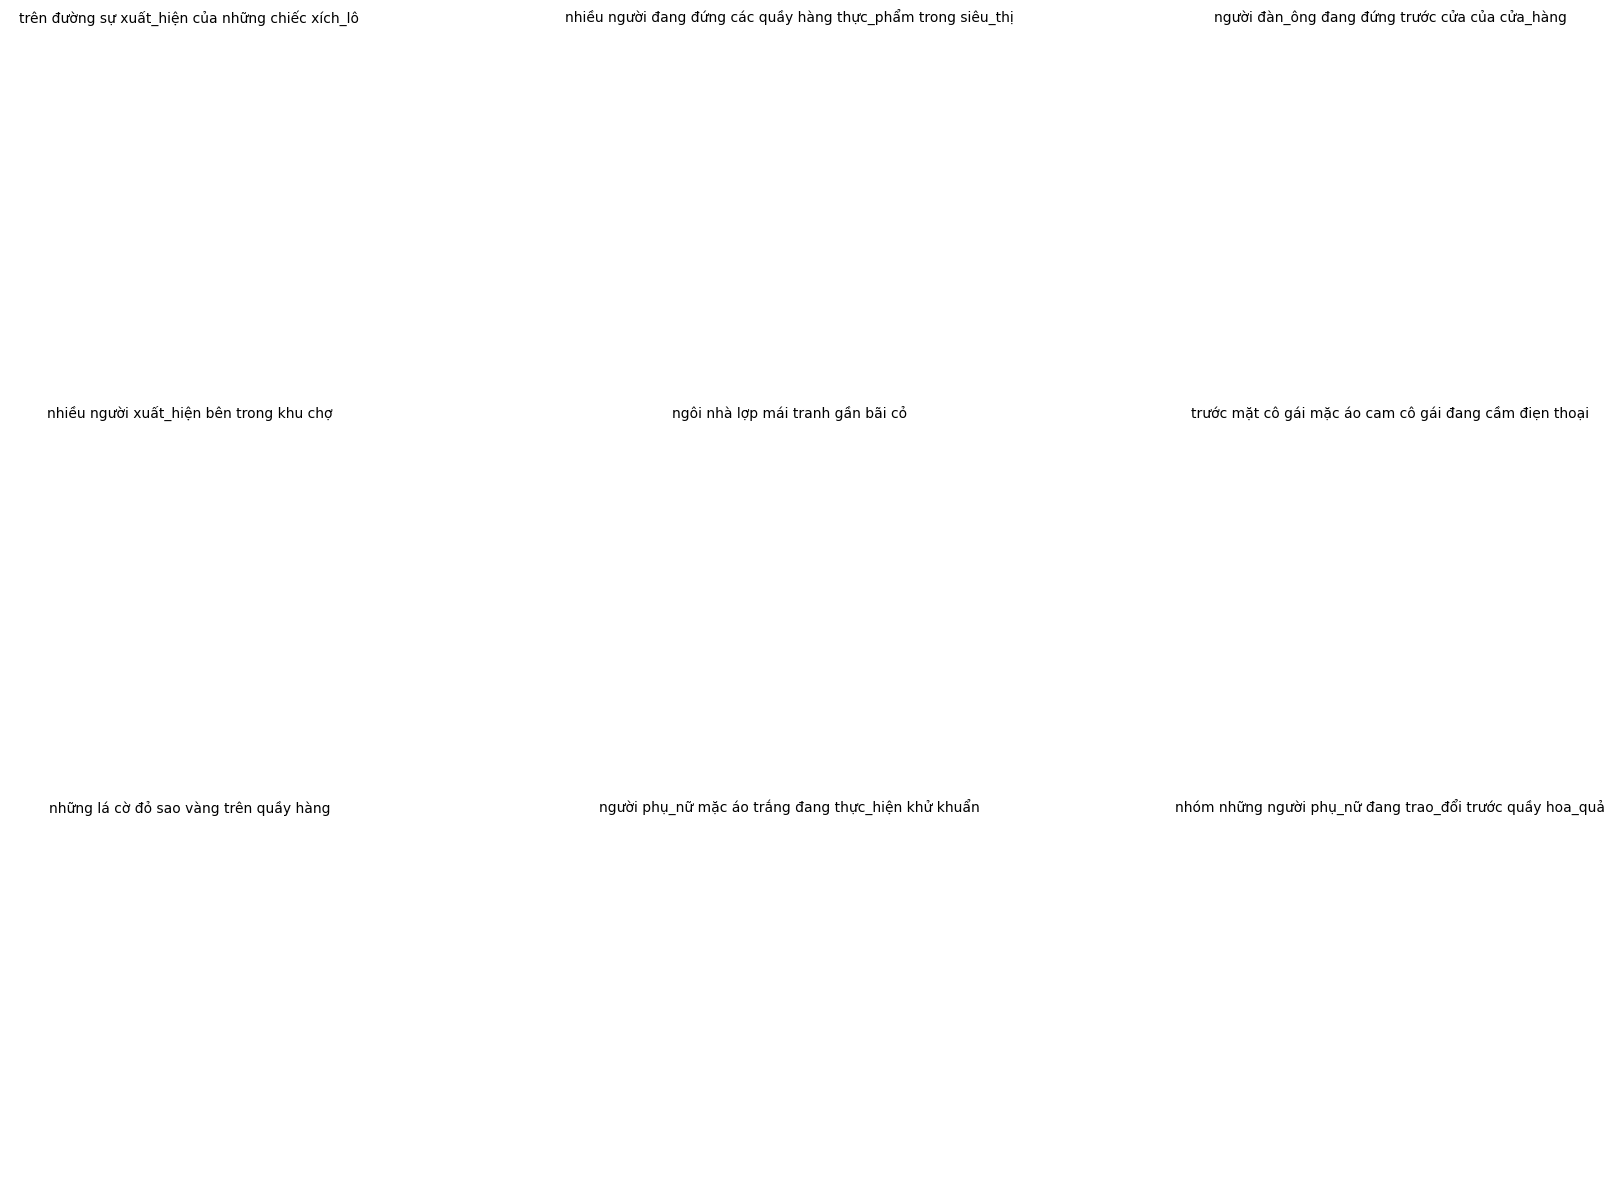

In [7]:

# Function to visualize a 3x3 grid of random images from the dataset
def visualize_random_image_grid(train_dataset, val_dataset, random_seed=None):
    # Optionally set a random seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)

    # Dataset choice
    datasets = {'train': train_dataset, 'val': val_dataset}
    subset_name = random.choice(list(datasets.keys()))  # Randomly select 'train' or 'val'
    selected_dataset = datasets[subset_name]

    # Set up a 3x3 grid for plotting
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))

    # Randomly select 9 images (or fewer if the dataset has fewer than 9)
    num_images = min(9, len(selected_dataset))
    random_indices = random.sample(range(len(selected_dataset)), num_images)

    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:  # Handle cases where there are fewer than 9 images
            ax.axis('off')  # Turn off the axes for empty grid cells
            continue

        # Get the random image and caption
        image_tensor = selected_dataset[random_indices[i]]['image']
        caption = selected_dataset[random_indices[i]]['text']

        # Convert the tensor to an RGB image
        rgb_image = tensor_to_image(image_tensor)

        # Plot the image
        ax.imshow(rgb_image)
        ax.axis('off')
        ax.set_title(caption, fontsize=10)

    # Adjust layout for a cleaner appearance
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_random_image_grid(train_dataset, val_dataset)

In [8]:
config = {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "MBartModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 2,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": False,
  "init_std": 0.02,
  "is_encoder_decoder": True,
  "max_position_embeddings": 256,
  "model_type": "mbart",
  "num_hidden_layers": 2,
  "pad_token_id": 1,
  "scale_embedding": False,
  "torch_dtype": "float32",
  "transformers_version": "4.10.2",
  "use_cache": True,
  "vocab_size": tokenizer.vocab_size + 5
}

In [9]:


class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.linear = nn.Linear(self.vit.config.hidden_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.vit(images)
        features = self.linear(features.last_hidden_state)
        features = self.relu(features)
        features = self.dropout(features)
        return features

# Define Transformer decoder
class Decoder(nn.Module):
    def __init__(self, max_seq_length):
        super(Decoder, self).__init__()
        self.config = BartConfig(**config)
        self.decoder = BartForConditionalGeneration(self.config)
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions):
        outputs = self.decoder(
            encoder_outputs = [features], ## Use [] instead of () Important!
            labels = captions)
        return outputs
    def generate(self, features, max_length = 50,device = 'cuda'):
        model_kwargs = {
            "encoder_outputs": [features], ## Use [] instead of () Important!
        }
        input_ids = torch.zeros((len(features), 1), device=device, dtype=torch.long)
        input_ids = input_ids * 1
        print(input_ids)
        output = self.decoder.generate(input_ids, num_beams=1, max_new_tokens = max_length, **model_kwargs)
        return output
class CaptioningModel(nn.Module):
    def __init__(self,embed_size,max_seq_length=30,device = 'cuda'):
        super(CaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(max_seq_length)
        self.device = device
        self.to(device)
    def train_one_iter(self,data):
        
        outputs = self.forward(data)
        
        self.loss = outputs.loss
        
        # Backward pass and optimization
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        
    def setup_training(self,lr):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
    
    def forward(self,data):
        images = data['images']
        captions = data['encodings']
        
        images = images.to(self.device)
        captions = captions.to(self.device)
        
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

learning_rate = 0.0001
num_epochs = 10
model = CaptioningModel(config['d_model'],30,device='cuda')
model.setup_training(learning_rate)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
def evalutate_model(model,val_dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            outputs = model(data)
            loss = outputs.loss.cpu().item()
            total_loss += loss
    model.train()
    return total_loss/len(val_dataloader)
            
            
            

In [11]:
model.train()
best_loss = 9999
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader,total = len(train_dataloader) )
    for i, data in enumerate(pbar):
        pbar.update(1)
        model.train_one_iter(data)
        if (i + 1)% 50 == 0:
            pbar.set_postfix_str('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataloader), model.loss.item()))
        if (i+1) % 200 == 0:
            eval_loss = evalutate_model(model,val_dataloader)
            if best_loss > eval_loss:
                best_loss = eval_loss
                torch.save(model.state_dict(),"best.pt")
            pbar.set_description_str(f"Evaluate loss: {eval_loss},best_loss: {best_loss}")
    pbar.update(1)
     

  0%|          | 1/235 [00:03<13:46,  3.53s/it]


KeyboardInterrupt: 

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict,"model.pt")

In [12]:
model.load_state_dict(torch.load("/kaggle/working/best.pt",map_location='cuda'))

/tmp/ipykernel_31/2603241931.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best.pt",map_location='cuda'))


<All keys matched successfully>

tensor([[0]], device='cuda:0')
[   0    0   36  152  981   52   11 2289  145   12    7  642   69    2]
  nhiều chiếc xe_máy đang được dựng bên trong của ngôi nhà 


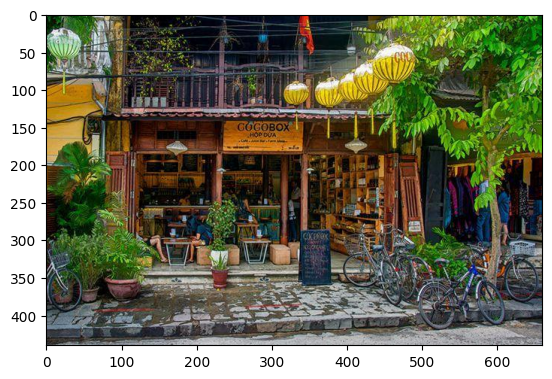

In [13]:
import matplotlib.pyplot as plt
transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),

    ])

model.eval()
def image_captioning(image_name: str,model,device = 'cuda'):
    pil_image = Image.open(image_name).convert('RGB')
    image = transform(pil_image).unsqueeze(0)
    image = image.to(device)
    features = model.encoder(image)
    out = model.decoder.generate(features)
    preds = out.detach().cpu().numpy()[0]
    print(preds)
    predict = [tokenizer._convert_id_to_token(i) for i in preds]
    predict = tokenizer.convert_tokens_to_string(predict).replace("<pad>","").replace("<s>","").replace("</s>","")
    print(predict)
    plt.imshow(np.asarray(pil_image))
    # plt.title(vocab.batch_decode(preds)[0])
    plt.show()
image_captioning("/kaggle/input/image-captioning/public-test-images/00000000933.jpg",model)

In [15]:
!pip install gradio

In [16]:
import gradio as gr
device = 'cuda'
model.eval()
def image_captioning_demo(inmage):
    pil_image = Image.fromarray(inmage)
    image = transform(pil_image).unsqueeze(0)
    image = image.to(device)
    features = model.encoder(image)
    out = model.decoder.generate(features)
    preds = out.detach().cpu().numpy()[0]
    predict = [tokenizer._convert_id_to_token(i) for i in preds]
    predict = tokenizer.convert_tokens_to_string(predict).replace("<pad>","").replace("<s>","").replace("</s>","")
    return predict

demo = gr.Interface(fn=image_captioning_demo, inputs="image", outputs="text")
demo.launch(share  = True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c18197ffb0f96a2f3e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
tokenizer.save_vocabulary('/kaggle/working/')